<a href="https://colab.research.google.com/github/AgnusSerena/CreditCardFakeNewsDetection/blob/main/Credit_Card_FakeNewsDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython import get_ipython
from IPython.display import display
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer


In [2]:
df = pd.read_csv('/content/creditcard_2023.csv')

In [3]:

X = df.drop(['id', 'Class'], axis=1, errors='ignore')
y = df['Class']


In [4]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
X_train = X_train[~y_train.isnull()]
y_train = y_train.dropna()
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [7]:
rf_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    min_samples_split=5,
    random_state=42
)

cv_scores = cross_val_score(rf_model, X_train_scaled, y_train, cv=5, scoring='f1')
print("\nCross-validation F1 scores:", cv_scores)
print("Average F1 score:", np.mean(cv_scores))

rf_model.fit(X_train_scaled, y_train)

/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_split.py:805: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=5.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted


Cross-validation F1 scores: [0. 0. 0. 0. 0.]
Average F1 score: 0.0


RandomForestClassifier(max_depth=10, min_samples_split=5, random_state=42)

In [8]:
imputer = SimpleImputer(strategy='most_frequent')
y_test = imputer.fit_transform(y_test.values.reshape(-1, 1))


In [9]:
X_test_scaled = np.nan_to_num(X_test_scaled)
mask = np.isfinite(X_test_scaled).all(axis=1) & np.isfinite(y_test).ravel()
X_test_scaled = X_test_scaled[mask]
y_test = y_test[mask]
y_test = y_test.ravel()

y_pred = rf_model.predict(X_test_scaled)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00       369

    accuracy                           1.00       369
   macro avg       1.00      1.00      1.00       369
weighted avg       1.00      1.00      1.00       369



/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:407: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


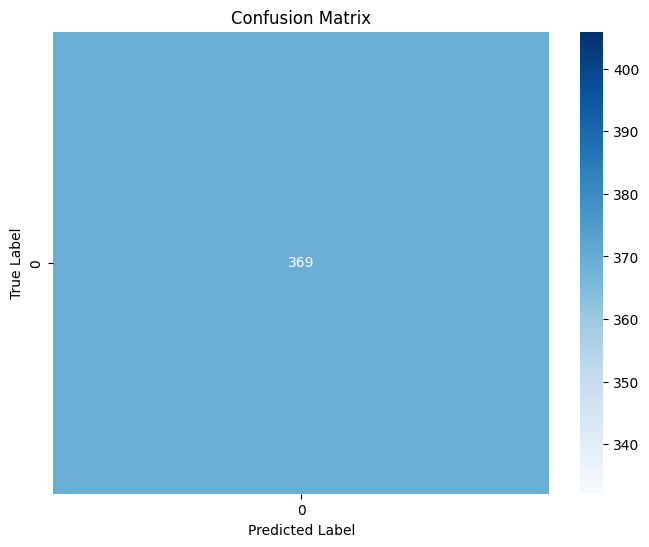

In [10]:
plt.figure(figsize=(8, 6))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

In [11]:
importance = rf_model.feature_importances_
feature_imp = pd.DataFrame({
    'Feature': X.columns,
    'Importance': importance
}).sort_values('Importance', ascending=False)

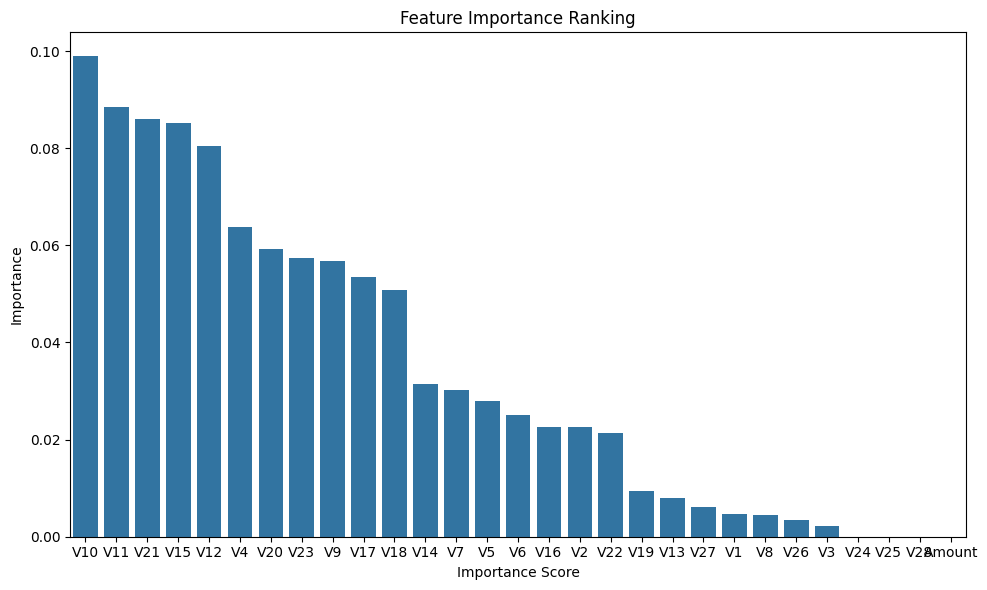

In [12]:

plt.figure(figsize=(10, 6))
sns.barplot(data=feature_imp, y='Importance', x='Feature')
plt.title('Feature Importance Ranking')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_ranking.py:1188: UndefinedMetricWarning: No positive samples in y_true, true positive value should be meaningless
  warnings.warn(


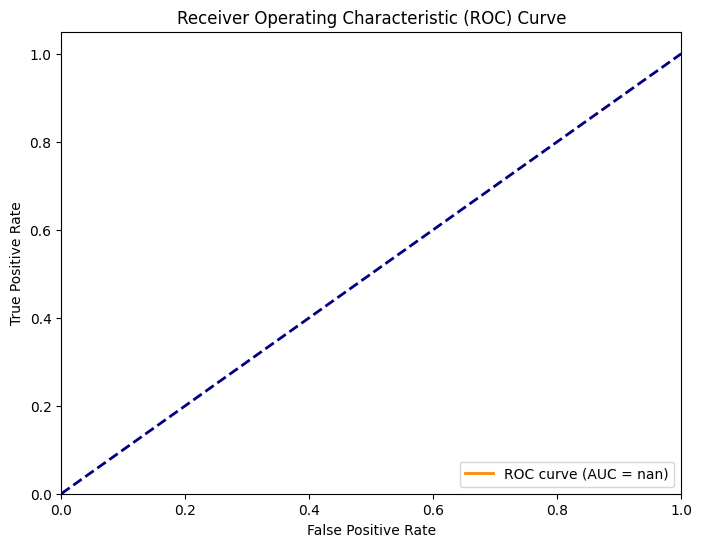

In [13]:
y_pred_proba = rf_model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()